In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from PanelInputDataGenerator import PanelInputDataGenerator
from Metrics import turn_predictions_into_binaries, plot_multilabel_pr_curve, create_classification_report_custom_binary_threshold,call_all_training_plots
products_and_features_table = pd.read_pickle('raw_data_1728678rows_x_77columns.pkl')
csa_data = PanelInputDataGenerator(products_and_features_table)
def create_input_data_for_one_time_windows_dict(csa_data,time_windows):
    csa_data.time_windows = time_windows
    csa_data.create_input_data()
    return csa_data.get_input_data()
time_windows_list = [
    [{'feature': [30, 36],'target': [36, 41]}],
    [{'feature': [25, 36],'target': [36, 41]}],
    [{'feature': [20, 36],'target': [36, 41]}],
    [{'feature': [15, 36],'target': [36, 41]}],
    [{'feature': [10, 36],'target': [36, 41]}],
    [{'feature': [5, 36],'target': [36, 41]}],
    [{'feature': [0, 36],'target': [36, 41]}]
]
input_datasets = [create_input_data_for_one_time_windows_dict(csa_data,time_windows) for time_windows in time_windows_list]
for i in range(len(input_datasets)):
    print(input_datasets[i]['X_train'].shape,input_datasets[i]['Y_train'].shape)

100%|████████████████████████████████████| 41159/41159 [06:13<00:00, 110.24it/s]


(30869, 6, 236) (30869, 21)
(30869, 11, 236) (30869, 21)
(30869, 16, 236) (30869, 21)
(30869, 21, 236) (30869, 21)
(30869, 26, 236) (30869, 21)
(30869, 31, 236) (30869, 21)
(30869, 36, 236) (30869, 21)


In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping

def create_LSTM(hidden_units, input_shape, output_shape,
                activation, lossfct):
    model = Sequential()
    model.add(
        LSTM(hidden_units,
             input_shape=input_shape,
             activation=activation[0]))
    model.add(Dense(units=output_shape, activation=activation[1]))
    model.compile(loss=lossfct, optimizer='adam',metrics=[tf.keras.metrics.Accuracy(),\
                                                          tf.keras.metrics.BinaryAccuracy(),\
                                                          tf.keras.metrics.MeanSquaredError(),\
                                                          tf.keras.metrics.Precision(),\
                                                          tf.keras.metrics.Recall(),\
                                                          tf.keras.metrics.TruePositives(),
                                                          tf.keras.metrics.AUC(multi_label=True)])
    return model

def evaluate_f1_score_of_lstm(input_data):
    model_lstm = create_LSTM(hidden_units=512, input_shape=input_data['X_train'].shape[1:], \
                       output_shape= input_data['Y_train'].shape[1], activation=['relu','sigmoid'],\
                            lossfct='binary_crossentropy')
    model_suffix = model_lstm.name.split("l")[1]
    metric_name = f"val_auc{model_suffix}"
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True,verbose=0)
    with tf.device('/GPU:0'):
        fit_history_lstm = model_lstm.fit(input_data['X_train'], input_data['Y_train'], \
        epochs=100, batch_size=512, verbose=0,validation_data=(input_data['X_valid'], input_data['Y_valid']),\
        callbacks = [early_stopping])
    report_panel_approach = create_classification_report_custom_binary_threshold(
        turn_predictions_into_binaries(model_lstm.predict(input_data['X_test']), 0.5),
        input_data['Y_test'],csa_data.all_products)
    return report_panel_approach.loc["micro avg"]["f1-score"]

In [26]:
import tqdm
f1scores = []
for input_data in tqdm.tqdm(input_datasets):
        f1scores.append([evaluate_f1_score_of_lstm(input_data) for _ in range(20)])
f1scores_data = pd.DataFrame(f1scores,index=[6,11,16,21,26,31,35]).T

  0%|                                                     | 0/7 [00:00<?, ?it/s]

 14%|██████▎                                     | 1/7 [06:10<37:03, 370.65s/it]

 29%|████████████▌                               | 2/7 [15:11<39:15, 471.05s/it]

 43%|██████████████████▊                         | 3/7 [27:02<38:42, 580.59s/it]

 57%|█████████████████████████▏                  | 4/7 [41:56<35:11, 703.98s/it]

 71%|██████████████████████████████            | 5/7 [1:00:40<28:30, 855.45s/it]

 86%|███████████████████████████████████▏     | 6/7 [1:25:48<17:57, 1077.39s/it]

100%|█████████████████████████████████████████| 7/7 [1:59:58<00:00, 1028.30s/it]


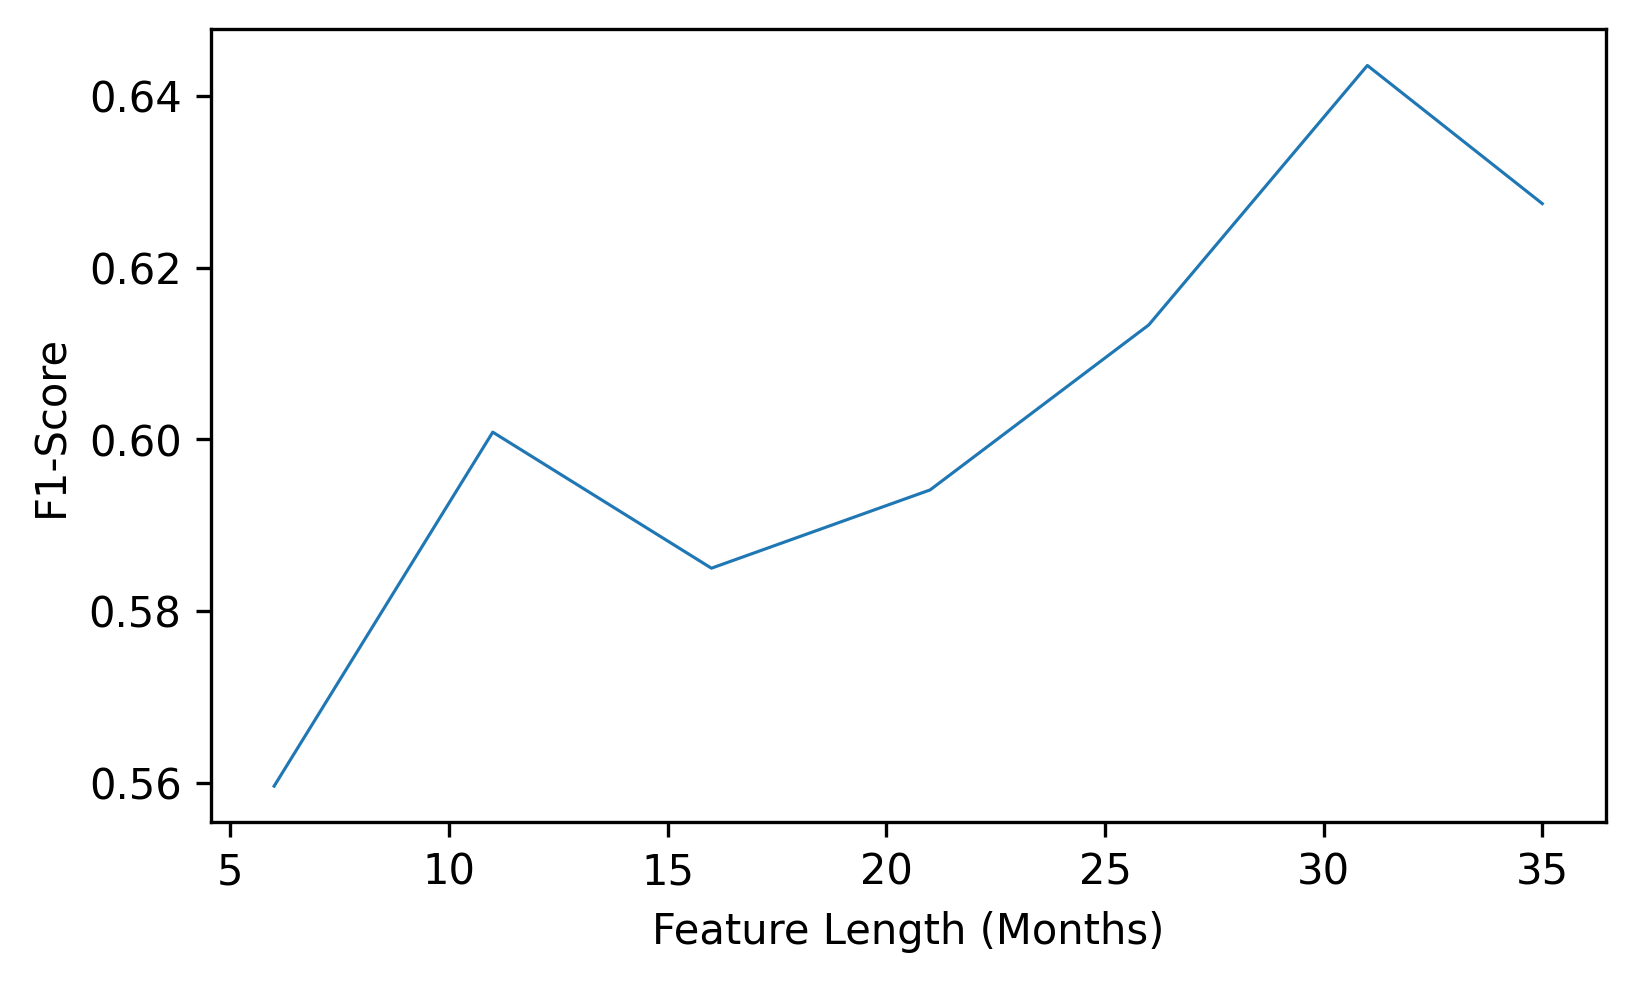

In [31]:
fig, ax = plt.subplots(figsize=(6, 3.5),dpi=300)
ax.plot(f1scores_data.max().index,f1scores_data.max(), lw=0.75)    
plt.xlabel("Feature Length (Months)")
plt.ylabel("F1-Score")
plt.savefig("maxperformanceperlength.png",bbox_inches='tight')
plt.show()